In [1]:
import numpy as np
import pandas as pd

In [2]:
from astroquery.gaia import Gaia

In [3]:
from matplotlib import pyplot as plt

First I will try it on the biggest field of view and then I will query the found result for subsets of it

In [4]:
f = 8.3e9
l = (c := 299_792_458) / f
D = 13.5
theta = 1.22 * l / D
radius = theta * 180 / np.pi / 2

In [5]:
f"θ_FOV = {theta * 180 / np.pi * 60 :.2f} arcminutes"

'θ_FOV = 11.22 arcminutes'

In [6]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time

# Galactic Center in galactic coords
gc_gal = SkyCoord(l=0 * u.deg, b=0 * u.deg, frame="galactic")

# Convert to ICRS (J2016)
gc_icrs = gc_gal.transform_to("icrs")
gc_icrs.location = None  # makes sure it's barycentric
gc_icrs.obstime = Time("J2016.0")

gc_icrs.ra.deg, gc_icrs.dec.deg

(np.float64(266.4049882865447), np.float64(-28.936177761791473))

In [7]:
radius = 0.1  # fov 12 arcminutes

In [8]:
query = f"""
SELECT designation, ra, dec, parallax, parallax_error, phot_bp_mean_mag, phot_g_mean_mag, bp_rp,
       SQRT(
         POWER(1.0857 / phot_bp_mean_flux_over_error, 2) +
         POWER(1.0857 / phot_rp_mean_flux_over_error, 2)
       ) AS bp_rp_error,
       phot_g_mean_mag - 5 * LOG10(distance_gspphot) + 5 AS abs_g_mag,
       SQRT(
         POWER(1.0857 / phot_g_mean_flux_over_error, 2) +
         POWER(5.0 / (2.302585093 * distance_gspphot) *
            ((distance_gspphot_upper - distance_gspphot_lower) / 2), 2)
       ) AS abs_g_mag_error
FROM gaiadr3.gaia_source
WHERE
CONTAINS(
  POINT('ICRS', ra, dec),
  CIRCLE('ICRS', {gc_icrs.ra.deg}, {gc_icrs.dec.deg}, {radius})
) = 1
AND distance_gspphot > 0
AND (distance_gspphot_upper - distance_gspphot_lower) > 0
AND parallax_over_error > 20
AND phot_g_mean_flux_over_error > 50
AND phot_rp_mean_flux_over_error > 20
AND phot_bp_mean_flux_over_error > 20
AND phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(phot_bp_mean_mag - phot_rp_mean_mag, 2)
AND phot_bp_rp_excess_factor > 1.0 + 0.015 * POWER(phot_bp_mean_mag - phot_rp_mean_mag, 2)
AND visibility_periods_used >= 8
AND astrometric_n_good_obs_al > 5
AND astrometric_chi2_al / (astrometric_n_good_obs_al - 5) 
    < 1.44 * GREATEST(1, EXP(-0.4 * (phot_g_mean_mag - 19.5)))
"""

In [9]:
job = Gaia.launch_job_async(query)

INFO: Query finished. [astroquery.utils.tap.core]


In [10]:
results = job.get_results()
print(results)

        designation                  ra         ...   abs_g_mag_error   
                                    deg         ...                     
---------------------------- ------------------ ... --------------------
Gaia DR3 4057470447939198976 266.48794749386786 ...  0.09073291803118003
Gaia DR3 4057470486600925184   266.489686098575 ...    0.039066173808412
Gaia DR3 4057470555320409600  266.4850687257671 ...  0.09804874819172045
Gaia DR3 4057476362116188032 266.49748753381704 ... 0.046332864437078666
Gaia DR3 4057481275558817280 266.33179631870837 ...  0.06777857888411466
Gaia DR3 4057481275558818560  266.3293508417944 ... 0.028862035117636693
Gaia DR3 4057481550436732928  266.3142384274843 ...  0.03683443513637385
Gaia DR3 4057482168911981312 266.45945911673044 ...  0.15359165947825637
Gaia DR3 4057482061536827008  266.3811239852798 ...  0.07988697903600842
                         ...                ... ...                  ...
Gaia DR3 4057488456744122240  266.4614329357456 ...

In [11]:
type(results)

astropy.table.table.Table

In [12]:
# Gaia sources in SkyCoord format
sources = SkyCoord(ra=results["ra"], dec=results["dec"], frame="icrs")

# Angular separation from GC in arcminutes
separations = sources.separation(gc_gal).arcminute

In [13]:
counts, bin_edges = np.histogram(separations, bins=100)
for i in range(1, len(counts)):
    counts[i] += counts[i - 1]
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

In [14]:
r_min = 3.02  # radius for fov for 15.4 GHz
r_max = 5.61  # radius for fov for  8.3 GHz

# Create colors: highlight bins in the target range
colors = [
    "crimson" if r_min <= center <= r_max else "#007847" for center in bin_centers
]

/home/obs/kperez/tmp/ipykernel_11812/2571871674.py:10: RuntimeWarning: divide by zero encountered in divide
  return c / (D * theta_FOV / 1.22) / 1e9


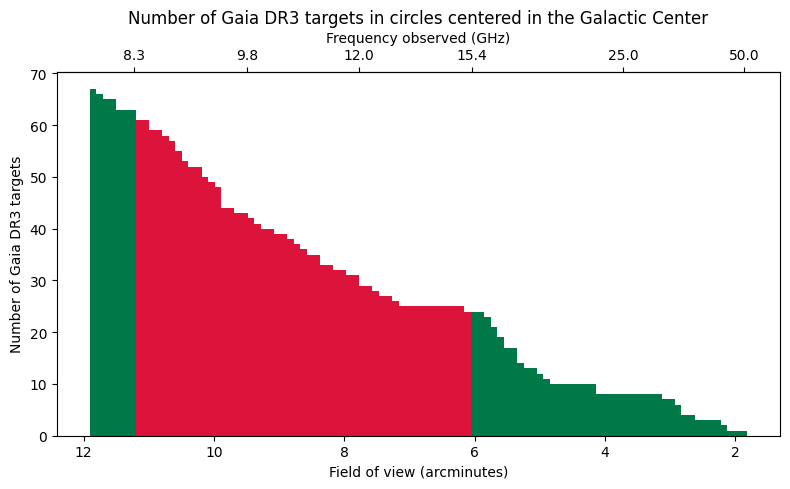

In [15]:
plt.figure(figsize=(8, 5))
plt.bar(
    bin_centers * 2, counts, width=2 * np.diff(bin_edges), color=colors, align="center"
)
plt.xlabel("Field of view (arcminutes)")
plt.ylabel("Number of Gaia DR3 targets")
plt.title("Number of Gaia DR3 targets in circles centered in the Galactic Center")
plt.gca().invert_xaxis()


def angle_to_freq(theta):
    theta_FOV = theta / 60 * np.pi / 180
    return c / (D * theta_FOV / 1.22) / 1e9


def freq_to_angle(f):
    theta_FOV = 1.22 * (c / f) / D
    return theta_FOV * 180 / np.pi * 60 / 1e9


secax = plt.gca().secondary_xaxis("top", functions=(freq_to_angle, angle_to_freq))
secax.set_xlabel("Frequency observed (GHz)")

# Format frequency ticks if needed
m1 = (2 * freq_to_angle(8.3) + freq_to_angle(15.4)) / 3
m2 = (freq_to_angle(8.3) + 2 * freq_to_angle(15.4)) / 3
secax.set_xticks(
    [8.3, angle_to_freq(m1), angle_to_freq(m2), 15.4, 25, 50, 1000]
)  # Optional: select key ticks

plt.tight_layout()
plt.savefig("gaia_dr3_targets_in_gc_per_fov.png")
plt.show()

Red marks MeerKAT's band 5b fields of view

## Distance estimates

In [16]:
from scipy.stats import norm
from scipy.integrate import simpson

In [17]:
# Bailer-Jones prior parameters
L = 770  # kpc

In [18]:
def posterior_distance(parallax, parallax_error, L=1.35, r_max=10000.0, dr=0.01):
    """Computes the posterior distance PDF for a given parallax using Bailer-Jones method."""
    r = np.arange(dr, r_max, dr)

    var = parallax_error**2
    likelihood = norm.pdf(parallax, loc=1 / r, scale=parallax_error)  # p( parallax | r)
    prior = r**2 * np.exp(-r / L)
    posterior = likelihood * prior
    norm_posterior = posterior / simpson(posterior, r)

    cdf = np.cumsum(norm_posterior) * dr
    median = r[np.searchsorted(cdf, 0.5)]
    lo = r[np.searchsorted(cdf, 0.16)]
    hi = r[np.searchsorted(cdf, 0.84)]

    return median, (hi - lo) / 2


posterior_distance = np.vectorize(posterior_distance)


def naive_distance(parallax, parallax_error):
    return 1 / parallax, parallax_error / parallax**2


naive_distance = np.vectorize(naive_distance)

In [19]:
plx, plx_err = results["parallax"] / 1000, results["parallax_error"] / 1000

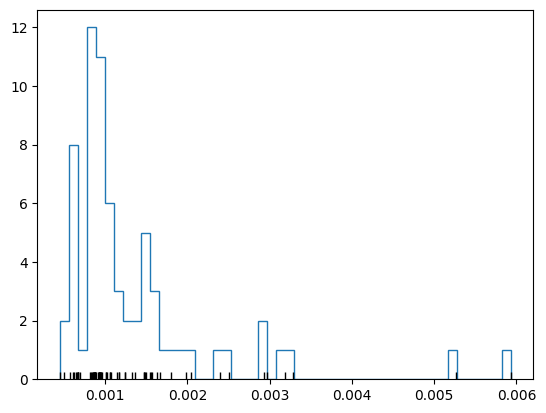

In [20]:
plt.hist(plx, bins=50, histtype="step")
plt.plot(plx, 0 * plx, "|", color="k", markersize=10);

In [21]:
naive_dist = naive_distance(plx, plx_err)
posterior_dist = posterior_distance(plx, plx_err)

/home/obs/kperez/tmp/ipykernel_11812/582881306.py:9: RuntimeWarning: invalid value encountered in divide
  norm_posterior = posterior / simpson(posterior, r)


In [22]:
M_naive = results["phot_g_mean_mag"] - 5 * np.log10(naive_dist[0]) + 5
safe_dist = np.where(naive_dist[0] != 0, naive_dist[0], 1e-6)
M_naive_err = (5 / (np.log(10) * safe_dist)) * naive_dist[1]

M_bayes = results["phot_g_mean_mag"] - 5 * np.log10(posterior_dist[0]) + 5
M_bayes_err = (5 / (np.log(10) * posterior_dist[0])) * posterior_dist[1]

Text(0.5, 1.0, 'Hertzsprung–Russell Diagram')

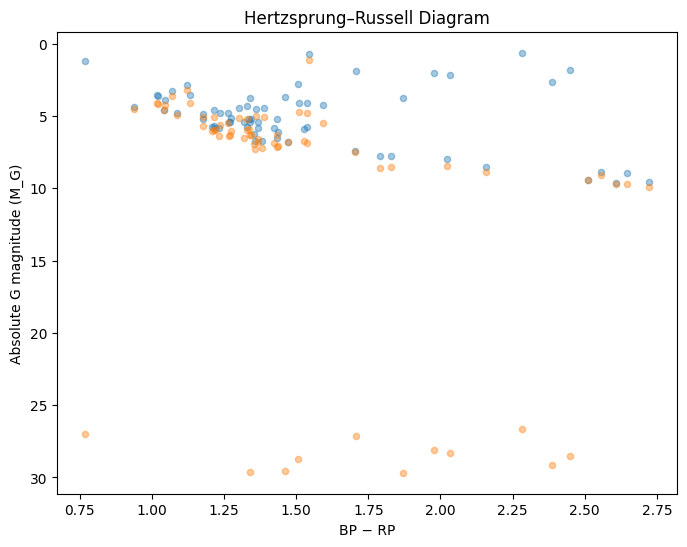

In [29]:
color = results["bp_rp"]

# mask = (results['parallax'] > 0) & ~np.isnan(color) & ~np.isnan(abs_mag)
# color = color[mask]
# abs_mag = abs_mag[mask]

plt.figure(figsize=(8, 6))
plt.scatter(color, M_naive, s=20, alpha=0.4)
plt.scatter(color, M_bayes, s=20, alpha=0.4)
plt.gca().invert_yaxis()
plt.xlabel("BP − RP")
plt.ylabel("Absolute G magnitude (M_G)")
plt.title("Hertzsprung–Russell Diagram")

In [24]:
from scipy.stats import multivariate_normal


def calculate_density(colors, magnitudes, color_err, mag_err):
    x_min, x_max = colors.min(), colors.max()
    y_min, y_max = magnitudes.min(), magnitudes.max()
    x = np.linspace(x_min, x_max, 300)
    y = np.linspace(10, 1, 300)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    density = np.zeros_like(X)

    for cx, cy, sx, sy in zip(colors, magnitudes, color_err, mag_err):
        if not (np.isfinite(cx) and np.isfinite(cy) and sx > 0 and sy > 0):
            continue
        cov = [[sx**2, 0], [0, sy**2]]
        rv = multivariate_normal(mean=[cx, cy], cov=cov)
        density += rv.pdf(pos)
    return X, Y, density / np.max(density)


X_b, Y_b, density_bayes = calculate_density(color, M_bayes, color / 100, M_bayes_err)

In [25]:
X_n, Y_n, density_naive = calculate_density(color, M_naive, color / 100, M_naive_err)

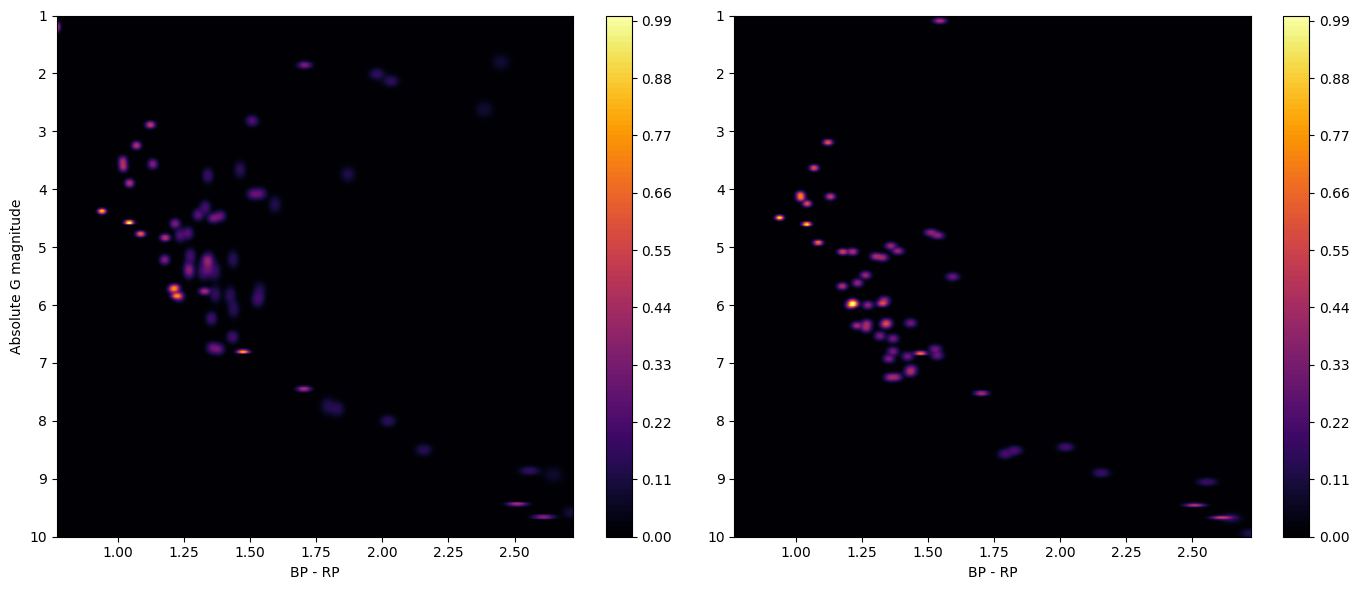

In [26]:
# Plot
fig, (axl, axr) = plt.subplots(1, 2, figsize=(14, 6))

naive = axl.contourf(X_n, Y_n, density_naive, levels=100, cmap="inferno")
axl.set_xlabel("BP - RP")
axl.set_ylabel("Absolute G magnitude")
axl.invert_yaxis()
fig.colorbar(naive)

bayes = axr.contourf(X_b, Y_b, density_bayes, levels=100, cmap="inferno")
axr.set_xlabel("BP - RP")
axr.invert_yaxis()
fig.colorbar(bayes)

fig.tight_layout()
plt.show()

In [27]:
X_g, Y_g, density_gaia = calculate_density(
    results["bp_rp"],
    results["abs_g_mag"],
    results["bp_rp_error"],
    results["abs_g_mag_error"],
)

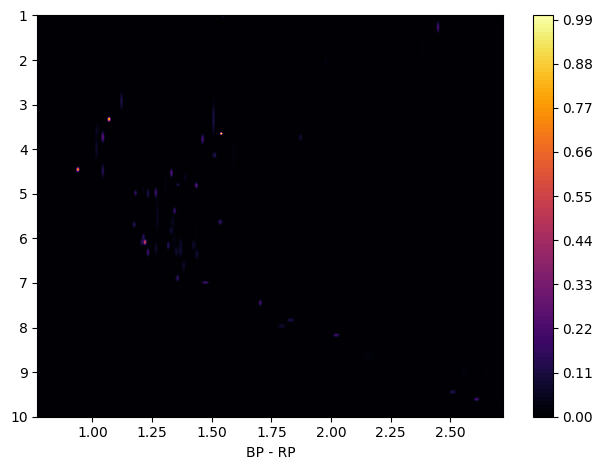

In [28]:
ax = plt.gca()
gaia_hr = ax.contourf(X_g, Y_g, density_gaia, levels=100, cmap="inferno")
ax.set_xlabel("BP - RP")
ax.invert_yaxis()

plt.colorbar(gaia_hr)
plt.tight_layout()